# EPA/EIA Crosswalk Exploration
Defining representative ramp rates depends on what is 'normal' at each plant. Defining normal operation should be easier after bringing in information about fuel, technology type, etc from EIA data.

The EPA CAMD team released a mapping between EIA and EPA units. They describe it, however, as a work in progress. This notebook explores this mapping and any associated quality or completeness concerns.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.data.load_dataset import load_epacems
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Validation/Exploration

In [3]:
release = 'https://github.com/USEPA/camd-eia-crosswalk/releases/download/v0.2.1/'
cwalk = pd.read_csv(release + 'epa_eia_crosswalk.csv')
# fields = pd.read_csv(release + 'field_descriptions.csv')

In [4]:
cwalk.head()

,SEQUENCE_NUMBER,CAMD_STATE,CAMD_FACILITY_NAME,CAMD_PLANT_ID,CAMD_UNIT_ID,CAMD_GENERATOR_ID,CAMD_NAMEPLATE_CAPACITY,CAMD_FUEL_TYPE,CAMD_LATITUDE,CAMD_LONGITUDE,...,EIA_LATITUDE,EIA_LONGITUDE,EIA_RETIRE_YEAR,PLANT_ID_CHANGE_FLAG,MOD_EIA_PLANT_ID,MOD_EIA_BOILER_ID,MOD_EIA_GENERATOR_ID_BOILER,MOD_EIA_GENERATOR_ID_GEN,MATCH_TYPE_GEN,MATCH_TYPE_BOILER
0,1.0,AL,Barry,3,1,1,153.1,Pipeline Natural Gas,31.0069,-88.0103,...,31.0069,-88.0103,0.0,0.0,3.0,1,1,1,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...
1,2.0,AL,Barry,3,2,2,153.1,Pipeline Natural Gas,31.0069,-88.0103,...,31.0069,-88.0103,0.0,0.0,3.0,2,2,2,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...
2,3.0,AL,Barry,3,3,3,272.0,NaN,31.0069,-88.0103,...,31.0069,-88.0103,2015.0,0.0,3.0,3,3,3,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...
3,4.0,AL,Barry,3,4,4,403.8,Coal,31.0069,-88.0103,...,31.0069,-88.0103,0.0,0.0,3.0,4,4,4,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...
4,5.0,AL,Barry,3,5,5,788.8,Coal,31.0069,-88.0103,...,31.0069,-88.0103,0.0,0.0,3.0,5,5,5,3_1_Generator (generators) match on plant and ...,6_1_EnviroAssoc (boilers and generators) match...


In [5]:
cwalk.columns

Index(['SEQUENCE_NUMBER', 'CAMD_STATE', 'CAMD_FACILITY_NAME', 'CAMD_PLANT_ID',
       'CAMD_UNIT_ID', 'CAMD_GENERATOR_ID', 'CAMD_NAMEPLATE_CAPACITY',
       'CAMD_FUEL_TYPE', 'CAMD_LATITUDE', 'CAMD_LONGITUDE', 'CAMD_STATUS',
       'CAMD_STATUS_DATE', 'CAMD_RETIRE_YEAR', 'MOD_CAMD_UNIT_ID',
       'MOD_CAMD_GENERATOR_ID', 'EIA_STATE', 'EIA_PLANT_NAME', 'EIA_PLANT_ID',
       'EIA_GENERATOR_ID', 'EIA_NAMEPLATE_CAPACITY', 'EIA_BOILER_ID',
       'EIA_UNIT_TYPE', 'EIA_FUEL_TYPE', 'EIA_LATITUDE', 'EIA_LONGITUDE',
       'EIA_RETIRE_YEAR', 'PLANT_ID_CHANGE_FLAG', 'MOD_EIA_PLANT_ID',
       'MOD_EIA_BOILER_ID', 'MOD_EIA_GENERATOR_ID_BOILER',
       'MOD_EIA_GENERATOR_ID_GEN', 'MATCH_TYPE_GEN', 'MATCH_TYPE_BOILER'],
      dtype='object')

### Evaluate complexity of record linkage
Direct matches are easier to trust. `MATCH_TYPE_GEN` explains how EPA did the matching - was it straightforward or fuzzy?

In [6]:
cwalk['MATCH_TYPE_GEN'].value_counts()

3_1_Generator (generators) match on plant and gen IDs  Step 1a: Exact match                           6174
CAMD Unmatched                                                                                         403
3_1_Generator (generators) match on plant and gen IDs  Step 1d: Modify IDs; remove leading letters     134
Manual CAMD Excluded                                                                                   120
Manual Match                                                                                            59
3_1_Generator (generators) match on plant and gen IDs  Step 1b: Modify IDs; remove special chars        24
3_1_Generator (generators) match on plant and gen IDs  Step 1c: Modify IDs; convert to numeric          16
Name: MATCH_TYPE_GEN, dtype: int64

Looks like mostly easy matches, only 150-ish fuzzy matches and 403 unmatched. From EPA docs, manual exclusions refer to cogen plants that don't sell power to the grid - industrial consumption only.

### What do unmatched records look like?

In [7]:
cwalk.query("MATCH_TYPE_GEN == 'CAMD Unmatched'")[['CAMD_FACILITY_NAME', 'CAMD_PLANT_ID',
       'CAMD_UNIT_ID', 'CAMD_GENERATOR_ID', 'CAMD_NAMEPLATE_CAPACITY', 'EIA_PLANT_NAME', 'EIA_PLANT_ID',
       'EIA_GENERATOR_ID', 'EIA_NAMEPLATE_CAPACITY', 'EIA_BOILER_ID',
       'EIA_UNIT_TYPE', 'EIA_FUEL_TYPE',]]

,CAMD_FACILITY_NAME,CAMD_PLANT_ID,CAMD_UNIT_ID,CAMD_GENERATOR_ID,CAMD_NAMEPLATE_CAPACITY,EIA_PLANT_NAME,EIA_PLANT_ID,EIA_GENERATOR_ID,EIA_NAMEPLATE_CAPACITY,EIA_BOILER_ID,EIA_UNIT_TYPE,EIA_FUEL_TYPE
137,Contra Costa Generating Station,228,10,7,359.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,Contra Costa Generating Station,228,9,6,359.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,"Morro Bay Power Plant, LLC",259,1,1,169.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,"Morro Bay Power Plant, LLC",259,2,2,169.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,"Morro Bay Power Plant, LLC",259,3,3,359.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6792,Okeechobee Clean Energy Center,60345,OCEC1A,1ST,593.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6793,Okeechobee Clean Energy Center,60345,OCEC1B,1B,376.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6794,Okeechobee Clean Energy Center,60345,OCEC1B,1ST,593.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6795,Okeechobee Clean Energy Center,60345,OCEC1C,1C,376.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Unmatched units have no EIA info, as expected, but do have a `CAMD_GENERATOR_ID` and `CAMD_NAMEPLATE_CAPACITY`. That is interesting because the raw CEMS data does not. Where does this come frome?

UPDATE: there are 4 ways to access CEMS data, and each one has different data. The REST API /facilities has this info and more plant and unit metadata, seemingly independent from the EIA. Could be useful to fill gaps. Hopefully they are consistent...

### Unit-to-Unit relationships - mostly one-to-one or lots of many-to-many?

In [8]:
cwalk.nunique().sort_values(ascending=False)

SEQUENCE_NUMBER                6527
CAMD_STATUS_DATE               2686
CAMD_UNIT_ID                   1730
MOD_CAMD_UNIT_ID               1730
CAMD_PLANT_ID                  1669
CAMD_FACILITY_NAME             1665
CAMD_LONGITUDE                 1648
CAMD_LATITUDE                  1628
EIA_PLANT_ID                   1542
EIA_PLANT_NAME                 1542
MOD_EIA_PLANT_ID               1531
EIA_LONGITUDE                  1529
EIA_LATITUDE                   1525
EIA_NAMEPLATE_CAPACITY         1255
CAMD_NAMEPLATE_CAPACITY        1121
CAMD_GENERATOR_ID               936
EIA_GENERATOR_ID                902
MOD_CAMD_GENERATOR_ID           887
MOD_EIA_GENERATOR_ID_GEN        856
EIA_BOILER_ID                   438
MOD_EIA_BOILER_ID               328
MOD_EIA_GENERATOR_ID_BOILER     118
CAMD_STATE                       51
EIA_STATE                        49
EIA_FUEL_TYPE                    23
CAMD_FUEL_TYPE                   13
CAMD_RETIRE_YEAR                 12
EIA_RETIRE_YEAR             

In [9]:
# how many CEMS units have multiple generators?
cwalk.groupby(by=['CAMD_PLANT_ID', 'CAMD_UNIT_ID']).size().gt(1).mean()

0.2308682855040471

23% of combustors feed more than one generator

In [10]:
# how many generators have multiple CEMS units?
cwalk.groupby(by=['CAMD_PLANT_ID', 'CAMD_GENERATOR_ID']).size().gt(1).mean()

0.13994540491355778

14% of generators are fed by multiple combustors

In [11]:
# many to many: where combustors feed multiple generators, how many of those generators are fed by multiple combustors?
_filter = cwalk.groupby(by=['CAMD_PLANT_ID', 'CAMD_UNIT_ID']).size().gt(1).rename('has_multi_combust')
multi_gen = cwalk[['CAMD_PLANT_ID', 'CAMD_UNIT_ID', 'CAMD_GENERATOR_ID']].merge(_filter, on=['CAMD_PLANT_ID', 'CAMD_UNIT_ID'], how='left')
multi_gen

,CAMD_PLANT_ID,CAMD_UNIT_ID,CAMD_GENERATOR_ID,has_multi_combust
0,3,1,1,False
1,3,2,2,False
2,3,3,3,False
3,3,4,4,False
4,3,5,5,False
...,...,...,...,...
6925,880107,AB02,NaN,False
6926,880107,AB03,NaN,False
6927,880107,AB04,NaN,False
6928,880108,BLR1,NaN,False


In [12]:
_filter = multi_gen.groupby(by=['CAMD_PLANT_ID', 'CAMD_GENERATOR_ID'])['has_multi_combust'].any()
(cwalk.groupby(by=['CAMD_PLANT_ID', 'CAMD_GENERATOR_ID']).size().gt(1) & _filter).mean()

0.09390354868061875

9% of generators are fed by multiple combustors where at least one of those combustors feeds multiple generators

In [13]:
# what do one-to-many units look like?
cwalk.groupby(by=['CAMD_PLANT_ID', 'CAMD_GENERATOR_ID'])['CAMD_UNIT_ID'].size().nlargest(10)

CAMD_PLANT_ID  CAMD_GENERATOR_ID
10745          BP15                 18
               ST1                  18
10865          GEN2                  9
               GEN3                  9
               GEN4                  9
               GEN5                  9
               GEN6                  9
               GEN7                  9
               GEN8                  9
891            1                     8
Name: CAMD_UNIT_ID, dtype: int64

In [14]:
# are there really 18 inputs to a single 410 MW steam turbine, much less a 13.5 MW turbine
cwalk.query("CAMD_PLANT_ID == 10745").sort_values(['CAMD_GENERATOR_ID', 'CAMD_UNIT_ID'])

,SEQUENCE_NUMBER,CAMD_STATE,CAMD_FACILITY_NAME,CAMD_PLANT_ID,CAMD_UNIT_ID,CAMD_GENERATOR_ID,CAMD_NAMEPLATE_CAPACITY,CAMD_FUEL_TYPE,CAMD_LATITUDE,CAMD_LONGITUDE,...,EIA_LATITUDE,EIA_LONGITUDE,EIA_RETIRE_YEAR,PLANT_ID_CHANGE_FLAG,MOD_EIA_PLANT_ID,MOD_EIA_BOILER_ID,MOD_EIA_GENERATOR_ID_BOILER,MOD_EIA_GENERATOR_ID_GEN,MATCH_TYPE_GEN,MATCH_TYPE_BOILER
4079,3770.0,MI,Midland Cogeneration Venture,10745,003,BP15,13.5,Pipeline Natural Gas,43.5861,-84.2242,...,43.5861,-84.2242,0.0,0.0,10745.0,NaN,NaN,BP15,3_1_Generator (generators) match on plant and ...,NaN
4082,3773.0,MI,Midland Cogeneration Venture,10745,004,BP15,13.5,Pipeline Natural Gas,43.5861,-84.2242,...,43.5861,-84.2242,0.0,0.0,10745.0,NaN,NaN,BP15,3_1_Generator (generators) match on plant and ...,NaN
4085,3776.0,MI,Midland Cogeneration Venture,10745,005,BP15,13.5,Pipeline Natural Gas,43.5861,-84.2242,...,43.5861,-84.2242,0.0,0.0,10745.0,NaN,NaN,BP15,3_1_Generator (generators) match on plant and ...,NaN
4088,3780.0,MI,Midland Cogeneration Venture,10745,006,BP15,13.5,Pipeline Natural Gas,43.5861,-84.2242,...,43.5861,-84.2242,0.0,0.0,10745.0,NaN,NaN,BP15,3_1_Generator (generators) match on plant and ...,NaN
4091,3783.0,MI,Midland Cogeneration Venture,10745,007,BP15,13.5,Pipeline Natural Gas,43.5861,-84.2242,...,43.5861,-84.2242,0.0,0.0,10745.0,NaN,NaN,BP15,3_1_Generator (generators) match on plant and ...,NaN
4094,3785.0,MI,Midland Cogeneration Venture,10745,008,BP15,13.5,Pipeline Natural Gas,43.5861,-84.2242,...,43.5861,-84.2242,0.0,0.0,10745.0,NaN,NaN,BP15,3_1_Generator (generators) match on plant and ...,NaN
4097,3788.0,MI,Midland Cogeneration Venture,10745,009,BP15,13.5,Pipeline Natural Gas,43.5861,-84.2242,...,43.5861,-84.2242,0.0,0.0,10745.0,NaN,NaN,BP15,3_1_Generator (generators) match on plant and ...,NaN
4100,3792.0,MI,Midland Cogeneration Venture,10745,010,BP15,13.5,Pipeline Natural Gas,43.5861,-84.2242,...,43.5861,-84.2242,0.0,0.0,10745.0,NaN,NaN,BP15,3_1_Generator (generators) match on plant and ...,NaN
4103,3795.0,MI,Midland Cogeneration Venture,10745,011,BP15,13.5,Pipeline Natural Gas,43.5861,-84.2242,...,43.5861,-84.2242,0.0,0.0,10745.0,NaN,NaN,BP15,3_1_Generator (generators) match on plant and ...,NaN
4106,3799.0,MI,Midland Cogeneration Venture,10745,012,BP15,13.5,Pipeline Natural Gas,43.5861,-84.2242,...,43.5861,-84.2242,0.0,0.0,10745.0,NaN,NaN,BP15,3_1_Generator (generators) match on plant and ...,NaN


In [15]:
# all states, 1 year
cols = ['plant_id_eia', 'unitid', 'operating_datetime_utc',
        'operating_time_hours', 'gross_load_mw', 'steam_load_1000_lbs',
        'heat_content_mmbtu', 'facility_id', 'unit_id_epa',
       ]

In [16]:
first_cems = (load_epacems(states=None, years=[2019], columns=cols, engine='pandas')
              .groupby('unit_id_epa', as_index=False).first())

In [17]:
# no duplicates on plant/unit
first_cems[first_cems.duplicated(subset=['plant_id_eia', 'unitid'])]

,unit_id_epa,plant_id_eia,unitid,operating_datetime_utc,operating_time_hours,gross_load_mw,steam_load_1000_lbs,heat_content_mmbtu,facility_id


In [18]:
first_cems.query('plant_id_eia == 10745', engine='python') # can't query pd.Int32 unless python engine is used

,unit_id_epa,plant_id_eia,unitid,operating_datetime_utc,operating_time_hours,gross_load_mw,steam_load_1000_lbs,heat_content_mmbtu,facility_id
3174,88567,10745,003,2019-01-01 05:00:00+00:00,0.0,0.0,NaN,0.000000,7755
3175,88568,10745,004,2019-01-01 05:00:00+00:00,1.0,89.0,NaN,934.299988,7755
3176,88569,10745,005,2019-01-01 05:00:00+00:00,1.0,87.0,NaN,940.400024,7755
3177,88570,10745,006,2019-01-01 05:00:00+00:00,0.0,0.0,NaN,0.000000,7755
3178,88571,10745,007,2019-01-01 05:00:00+00:00,0.0,0.0,NaN,0.000000,7755
3179,88572,10745,008,2019-01-01 05:00:00+00:00,0.0,0.0,NaN,0.000000,7755
3180,88573,10745,009,2019-01-01 05:00:00+00:00,0.0,0.0,NaN,0.000000,7755
3181,88574,10745,010,2019-01-01 05:00:00+00:00,0.0,0.0,NaN,0.000000,7755
3182,88575,10745,011,2019-01-01 05:00:00+00:00,0.0,0.0,NaN,0.000000,7755
3183,88576,10745,012,2019-01-01 05:00:00+00:00,1.0,88.0,NaN,990.200012,7755


There really are 18 inputs to that steam turbine... Some only report steam though, maybe because this is a cogen facility?

EPA docs did note that steam turbine generators have the option of reporting electrical OR steam production. I'll need to examine non-cogen steam-only units and see if they need special ramp rate treatment. They are currently excluded from analysis.

### EPA vs EIA

In [19]:
cwalk['CAMD_FUEL_TYPE'].value_counts()

Pipeline Natural Gas    4557
Coal                    1210
Diesel Oil               508
Natural Gas              174
Process Gas              147
Residual Oil             114
Other Gas                 53
Wood                      47
Other Oil                 34
Coal Refuse               14
Petroleum Coke            10
Tire Derived Fuel          3
Other Solid Fuel           2
Name: CAMD_FUEL_TYPE, dtype: int64

In [20]:
cwalk['EIA_FUEL_TYPE'].value_counts()

NG     4579
BIT     615
SUB     348
DFO     346
RC      107
KER      85
RFO      82
OG       48
WDS      48
BLQ      35
BFG      33
WC       25
LIG      20
PC        9
SGC       5
JF        5
LFG       4
MSW       4
SUN       3
TDF       2
WO        2
SGP       1
OBS       1
Name: EIA_FUEL_TYPE, dtype: int64

In [21]:
pd.options.display.max_rows = 100

In [22]:
cwalk.groupby(['EIA_FUEL_TYPE', 'CAMD_FUEL_TYPE'])[['SEQUENCE_NUMBER']].count().unstack().fillna('-')

SEQUENCE_NUMBER                                               \
CAMD_FUEL_TYPE            Coal Coal Refuse Diesel Oil Natural Gas Other Gas   
EIA_FUEL_TYPE                                                                 
BFG                          -           -          -           -       3.0   
BIT                      569.0           -        1.0         4.0       2.0   
BLQ                       15.0           -          -        10.0         -   
DFO                        1.0           -      339.0         1.0         -   
JF                           -           -        1.0           -         -   
KER                          -           -       63.0           -         -   
LFG                          -           -          -           -       4.0   
LIG                       19.0           -          -           -         -   
MSW                          -           -          -         2.0         -   
NG                        28.0           -       82.0       135.0      23.0   
OBS                          -           -          -           -         -   
OG                           -           -          -           -       3.0   
PC                           -           -          -           -         -   
RC                       106.0           -          -           -         -   
RFO                          -           -        1.0           -         -   
SGC                        4.0           -          -           -         -   
SGP                          -           -          -           -         -   
SUB                      333.0           -          -           -         -   
SUN                          -           -          -           -         -   
TDF                          -           -          -           -         -   
WC                        11.0        14.0          -           -         -   
WDS                        2.0           -          -         2.0         -   
WO                           -           -          -           -         -   

                                                                               \
CAMD_FUEL_TYPE Other Oil Other Solid Fuel Petroleum Coke Pipeline Natural Gas   
EIA_FUEL_TYPE                                                                   
BFG                    -                -              -                  2.0   
BIT                    -                -              -                 18.0   
BLQ                  1.0                -              -                  6.0   
DFO                  2.0                -              -                  3.0   
JF                   4.0                -              -                    -   
KER                 18.0                -              -                  4.0   
LFG                    -                -              -                    -   
LIG                    -                -              -                    -   
MSW                    -                -              -                  2.0   
NG                   1.0                -              -               4284.0   
OBS                    -                -              -                    -   
OG                     -                -              -                    -   
PC                     -                -            7.0                    -   
RC                     -                -              -                  1.0   
RFO                  1.0                -              -                 11.0   
SGC                    -                -              -                  1.0   
SGP                    -                -              -                  1.0   
SUB                    -                -              -                  7.0   
SUN                    -                -              -                  3.0   
TDF                    -                -              -                    -   
WC                     -                -              -                    -   
WDS             

<AxesSubplot:>

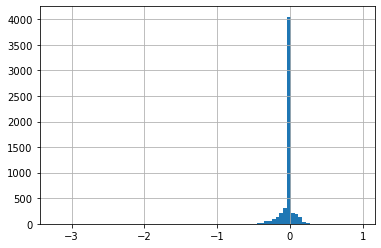

In [23]:
(cwalk['CAMD_NAMEPLATE_CAPACITY']
 .sub(cwalk['EIA_NAMEPLATE_CAPACITY'])
 .div(cwalk['CAMD_NAMEPLATE_CAPACITY'])
 .hist(bins=80,))# log=True))

<AxesSubplot:>

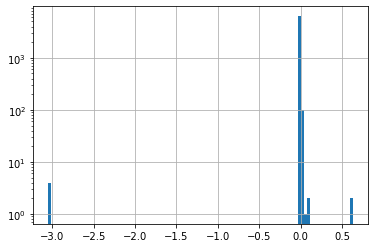

In [24]:
cwalk['CAMD_LATITUDE'].sub(cwalk['EIA_LATITUDE']).hist(bins=100, log=True)

<AxesSubplot:>

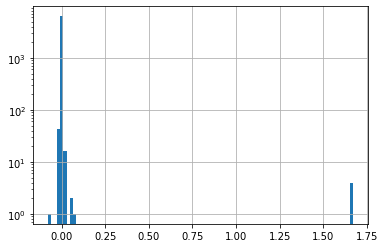

In [25]:
cwalk['CAMD_LONGITUDE'].sub(cwalk['EIA_LONGITUDE']).hist(bins=100, log=True)